<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/02_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Attention

As we know, There are two sequences now: the source and the target. We use the
former to predict the latter, and they may even have different lengths.

A typical example of a sequence-to-sequence problem is translation: A sentence
goes in (a sequence of words in English), and another sentence comes out (a
sequence of words in French). This problem can be tackled using an encoderdecoder
architecture.



We’ll start by generating a synthetic dataset and then use it to
illustrate the inner workings of:

1. encoder-decoder architecture, 
2. models to predict a target sequence from a source sequence, 
3. attention mechanisms, and 
4. multi-headed attention mechanism



##Setup

In [ ]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

Finished!


In [ ]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Dataset

Our data points are two-dimensional, so they can be visualized as an image, and
ordered, so they are a sequence.

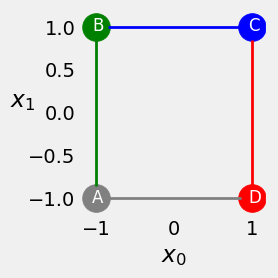

In [ ]:
fig = counter_vs_clock(draw_arrows=False)

Now, we can choose to draw it clockwise or counterclockwise

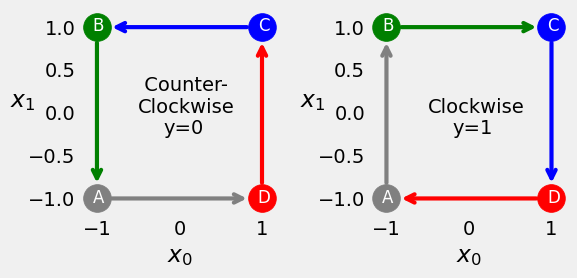

In [ ]:
fig = counter_vs_clock()

Since there are four corners to start from, and there are two directions to follow,
there are effectively eight possible sequences.

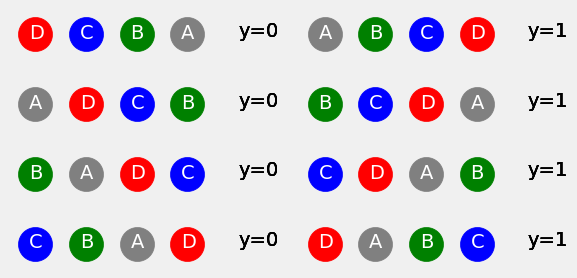

In [ ]:
fig = plot_sequences()

Let’s generate 128 random noisy squares.

In [ ]:
points, directions = generate_sequences(n=128, seed=13)

And then let’s visualize the first ten squares.

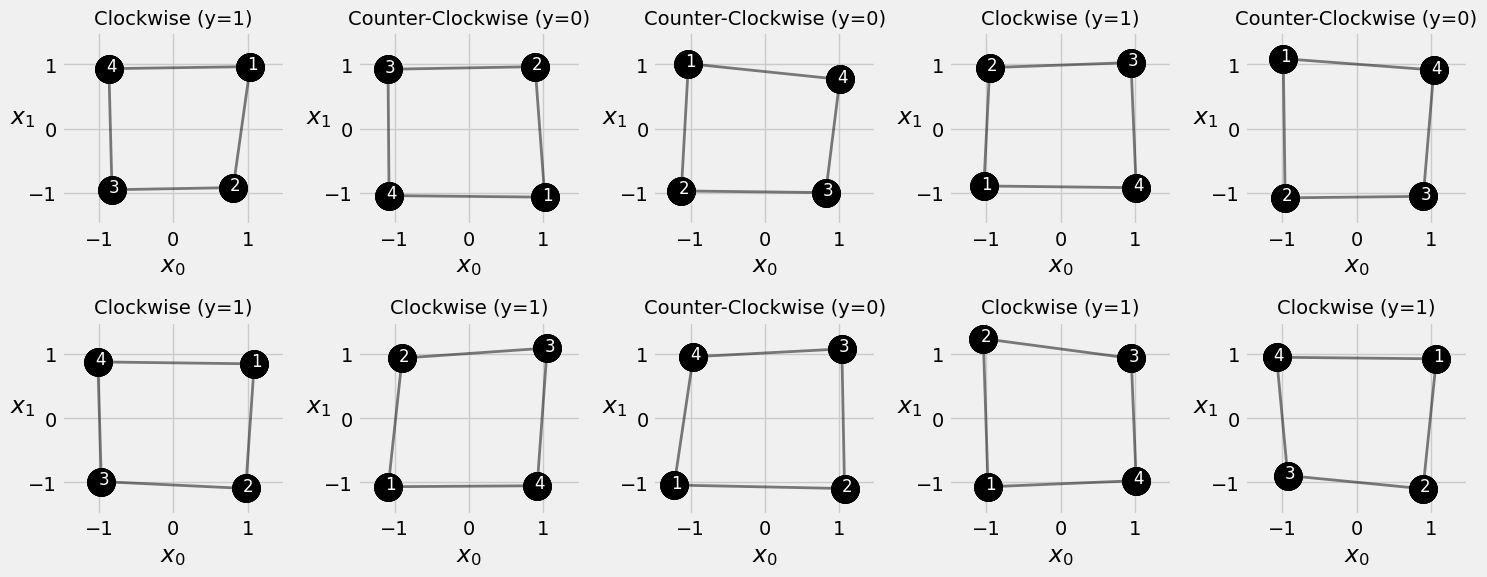

In [ ]:
fig = plot_data(points, directions)

##Recurrent Neural Networks

Recurrent neural networks are perfectly suited for sequence problems since they
take advantage of the underlying structure of the data, namely, the order of the
data points.

A hidden state is simply a vector. The size of the vector is up to
you. Really. You need to specify the number of hidden dimensions, which means
specifying the size of the vector that represents a hidden state. 

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn2.png?raw=1)

Let’s create a two dimensional
hidden state.

In [ ]:
hidden_state = torch.zeros(2)
hidden_state

tensor([0., 0.])

Since the final hidden state is a representation of the full sequence, that’s what
we’re going to use as features for our classifier.

There is a fundamental difference between CNNs and RNNs, though: While there
are several different convolutional layers, each learning its own filters, the RNN
cell is one and the same.

###RNN Cell

There is only one cell, which will learn a particular set of weights
and biases, and which will transform the inputs exactly the same
way in every step of the sequence.

Let’s take a look at some of the internals of an RNN cell.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn1.png?raw=1)

It has three main components:

1. A linear layer to transform the hidden state (in blue)
2. A linear layer to transform the data point from the sequence (in red)
3. An activation function, usually the hyperbolic tangent (TanH), which is applied to the sum of both transformed inputs

We can also represent them as equations:

$$
\Large
\begin{array}
&\text{RNN}: &\color{#0066CC}{t_h}&\color{#0066CC}{=}&\color{#0066CC}{W_{hh}}&\color{#0066CC}{h_{t-1}}&\color{#0066CC}{+}&\color{#0066CC}{b_{hh}}
\\
&\color{red}{t_x}& \color{red}{=} &\color{red}{W_{ih}}&\color{red}{x_{t}}&\color{red}{+}&\color{red}{b_{ih}}
\\
&\color{#0066CC}{h_t}&\color{#0066CC}{=}&\color{#0066CC}{\text{tanh}}&\color{#0066CC}{(t_h}&\color{#0066CC}{+}&\color{#0066CC}{t_x)}
\end{array}
$$

But there is no other cell, really; it is just the same cell over and over again.

So, in the second step of the
sequence, the updated hidden state will run through the very same linear layer the
initial hidden state ran through. The same goes for the second data point.

Let’s dive deeper into the internals of an RNN cell and look at it at the neuron level:

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn_cell_diagram.png?raw=1)

Since one can choose the number of hidden dimensions, I chose two dimensions,
simply because I want to be able to easily visualize the results. Hence, two blue
neurons are transforming the hidden state.


The number of red neurons transforming the data point will
necessarily be the same as the chosen number of hidden
dimensions since both transformed outputs need to be added
together. But this doesn’t mean the data points must have the
same number of dimensions.

Coincidentally, our data points have two coordinates, but even if
we had 25 dimensions, these 25 features would still be mapped
into two dimensions by the two red neurons.

Why hyperbolic tangent? Isn’t ReLU a better activation function?

The hyperbolic tangent has a "competitive advantage" here since it maps the feature
space to clearly defined boundaries: the interval (-1, 1). This guarantees that, at every step of the sequence, the hidden state is always within these boundaries.
Given that we have only one linear layer with which to transform the hidden
state, regardless of which step of the sequence it is being used in, it is definitely
convenient to have its values within a predictable range.

Now, let’s see how an RNN cell works in code.


In [ ]:
torch.manual_seed(19)

n_features = 2
hidden_dim = 2

rnn_cell = nn.RNNCell(input_size=n_features, hidden_size=hidden_dim)
rnn_state = rnn_cell.state_dict()
rnn_state

OrderedDict([('weight_ih',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih', tensor([0.4954, 0.6533])),
             ('bias_hh', tensor([-0.3565, -0.2904]))])

We can use these weights to create two linear layers:

In [ ]:
linear_input = nn.Linear(n_features, hidden_dim)
linear_hidden = nn.Linear(hidden_dim, hidden_dim)

with torch.no_grad():
  linear_input.weight = nn.Parameter(rnn_state["weight_ih"])
  linear_input.bias = nn.Parameter(rnn_state["bias_ih"])
  linear_hidden.weight = nn.Parameter(rnn_state["weight_hh"])
  linear_hidden.bias = nn.Parameter(rnn_state["bias_hh"])

Now, let’s work our way through the mechanics of the RNN cell! It all starts with
the initial hidden state representing the empty sequence:

In [ ]:
initial_hidden = torch.zeros(1, hidden_dim)
initial_hidden

tensor([[0., 0.]])

Then, we use the linear_hidden layer, to transform the
hidden state:

In [ ]:
th = linear_hidden(initial_hidden)
th

tensor([[-0.3565, -0.2904]], grad_fn=<AddmmBackward0>)

Now, let’s take look at a sequence of data points from our dataset:

In [ ]:
X = torch.as_tensor(points[0]).float()
X

tensor([[ 1.0349,  0.9661],
        [ 0.8055, -0.9169],
        [-0.8251, -0.9499],
        [-0.8670,  0.9342]])

As expected, four data points, two coordinates each.

In [ ]:
tx = linear_input(X[0:1])
tx

tensor([[0.7712, 1.4310]], grad_fn=<AddmmBackward0>)

We got both $t_x$ and $t_h$. Let’s add them together:

In [ ]:
addition = th + tx
addition

tensor([[0.4146, 1.1405]], grad_fn=<AddBackward0>)

Finally, the hyperbolic tangent activation function "compresses" the feature space
back into the `(-1, 1)` interval:

In [ ]:
torch.tanh(addition)

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

That’s the updated hidden state!

Now, let’s take a quick sanity check, feeding the same input to the original RNN cell:

In [ ]:
rnn_cell(X[0:1])

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)

Great, the values match.

We can also visualize this sequence of operations, assuming that every hidden
space "lives" in a feature space delimited by the boundaries given by the hyperbolic
tangent. 

So, the initial hidden state (0, 0) sits at the center of this feature space.

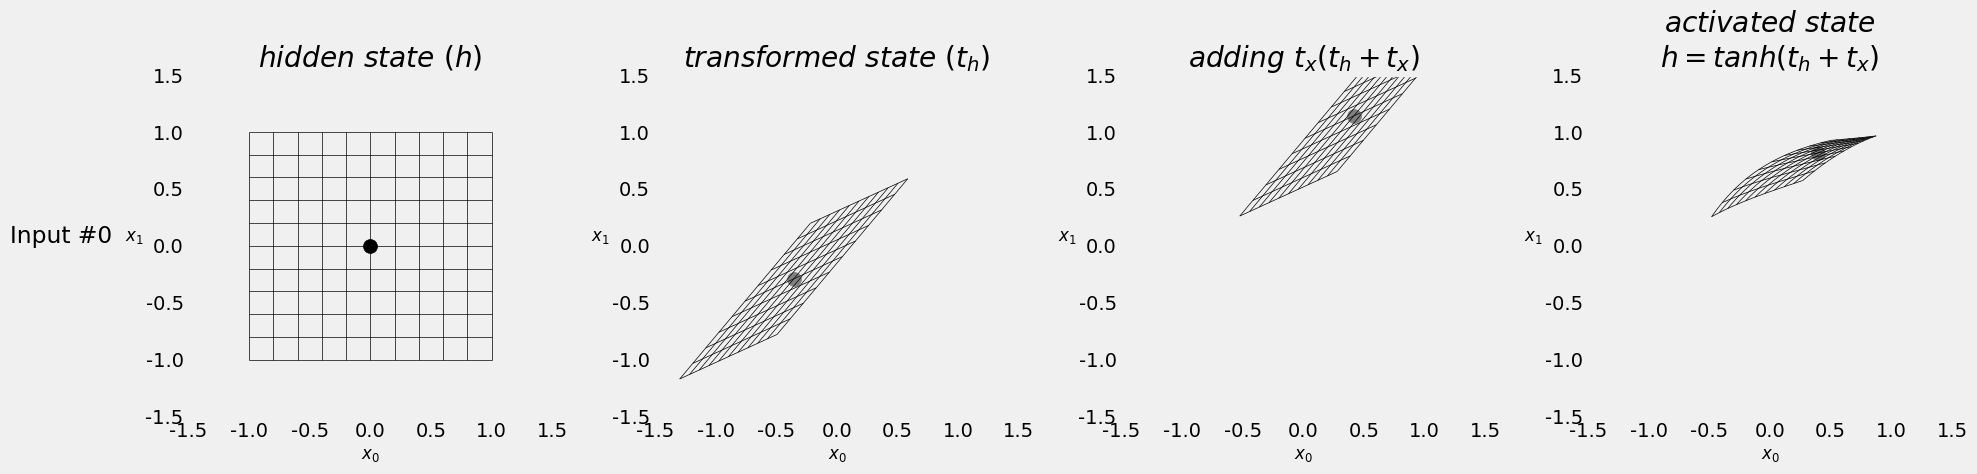

In [ ]:
fig = figure8(linear_hidden, linear_input, X)

The transformed hidden state went through an affine transformation.

The whole feature space was translated to the right and up. And
then, in the right most plot, the hyperbolic tangent works its magic and brings the whole feature space back to the `(-1, 1)` range. That was the first step in the journey of a hidden state.

I guess it is time to feed the full sequence to the RNN cell, right?

In [ ]:
# WRONG!
rnn_cell(X)

tensor([[ 0.3924,  0.8146],
        [ 0.7864,  0.5266],
        [-0.0047, -0.2897],
        [-0.6817,  0.1109]], grad_fn=<TanhBackward0>)

This is wrong! Remember, the RNN cell has two inputs: one hidden state and one
data point.

Where is the hidden state then?

That’s exactly the problem! If not provided, it defaults to the zeros corresponding
to the initial hidden state. 

So, the call above is not processing four steps of a
sequence, but rather processing the first step of what it is assuming to be four
sequences.

To effectively use the RNN cell in a sequence, we need to loop over the data points
and provide the updated hidden state at each step:

In [ ]:
hidden = torch.zeros(1, hidden_dim)
for i in range(X.shape[0]):
  output = rnn_cell(X[i: i + 1], hidden)
  print(output)
  hidden = output

tensor([[0.3924, 0.8146]], grad_fn=<TanhBackward0>)
tensor([[ 0.4347, -0.0481]], grad_fn=<TanhBackward0>)
tensor([[-0.1521, -0.3367]], grad_fn=<TanhBackward0>)
tensor([[-0.5297,  0.3551]], grad_fn=<TanhBackward0>)


Now we’re talking! The last hidden state, `(-0.5297, 0.3551)`, is the representation of
the full sequence.

As you can
easily see what I call "the journey of a hidden state": It is transformed, translated
(adding the input), and activated many times over. 

Moreover, you can also see that
the data points are independently transformed—the model will learn the best way
to transform them.

At this point, you may be thinking:

Looping over the data points in a sequence?! That looks like a lot of
work!

Instead of an RNN cell, we can use a full-fledged…



###RNN Layer

The `nn.RNN` layer takes care of the hidden state handling for us, no matter how long
the input sequence is.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/rnn_cell_diagram_seq.png?raw=1)

So, we can
easily create a full-fledged RNN like that:

In [ ]:
torch.manual_seed(19)

n_features = 2
hidden_dim = 2

rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
rnn.state_dict()

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904]))])

Let’s illustrate the differences between shapes by creating a "batch" containing
three sequences, each having four data points (corners), with each data point
having two coordinates. 

Its shape is (3, 4, 2), and it is an example of a batch-first
tensor (N, L, F), like a mini-batch you’d get from a data loader:

In [ ]:
batch = torch.as_tensor(points[:3]).float()
batch.shape

<ipython-input-23-2a03d7664898>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  batch = torch.as_tensor(points[:3]).float()


torch.Size([3, 4, 2])

Since RNNs use sequence-first by default, we could explicitly change the shape of
the batch using `permute()` to flip the first two dimensions:

In [ ]:
permuted_batch = batch.permute(1, 0, 2)
permuted_batch.shape

torch.Size([4, 3, 2])

Now the data is in an "RNN-friendly" shape, and we can run it through a regular
RNN to get two sequence-first tensors back:

In [ ]:
torch.manual_seed(19)

rnn = nn.RNN(input_size=n_features, hidden_size=hidden_dim)
output, final_hidden = rnn(permuted_batch)
output.shape, final_hidden.shape

(torch.Size([4, 3, 2]), torch.Size([1, 3, 2]))

For simple RNNs, the last element of the output is the final
hidden state!

In [ ]:
(output[-1] == final_hidden).all()

tensor(True)

Once we’re done with the RNN, we can turn the data back to our familiar batchfirst
shape:

In [ ]:
batch_hidden = final_hidden.permute(1, 0, 2)
batch.shape

torch.Size([3, 4, 2])

Alternatively, we could set the RNN’s `batch_first` argument to True so we can use the batch above without any
modifications:

In [ ]:
torch.manual_seed(19)

rnn_batch_first = nn.RNN(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
output, final_hidden = rnn_batch_first(batch)
output.shape, final_hidden.shape

(torch.Size([3, 4, 2]), torch.Size([1, 3, 2]))

On the one hand, this can lead to confusion. On the other hand, most of the time we
won’t be handling the hidden state, and we’ll handle the batch-first output instead.

###Stacked RNN

First, take one RNN and feed it a sequence of data points. Next, take another RNN
and feed it the sequence of outputs produced by the first RNN. There you go—you
have a stacked RNN where each of the RNNs is considered a "layer" of the stacked
one.

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/stacked_rnn.png?raw=1)

Each "layer" starts with its own initial hidden state and produces its own final
hidden state. The output of the stacked RNN—that is, the hidden states at each
step of the sequence—are the hidden states of the top-most layer.

Let’s create a stacked RNN with two layers.

In [ ]:
torch.manual_seed(19)

rnn_stacked = nn.RNN(input_size=2, hidden_size=2, num_layers=2, batch_first=True)
state = rnn_stacked.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l1',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l1',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l1', tensor([-0.3163, -0.2153])),
             ('bias_hh_l1', tensor([ 0.0722, -0.3242]))])

Now, let’s create two simple RNNs and use the weights and biases above to set
their weights accordingly.

In [ ]:
rnn_layer0 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_layer1 = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_layer0.load_state_dict(dict(list(state.items())[:4]))
rnn_layer1.load_state_dict(dict([(k[:-1] + "0", v) for k, v in list(state.items())[:4]]))

<All keys matched successfully>

Now, let’s make a batch containing one sequence from our synthetic dataset.

In [ ]:
x = torch.as_tensor(points[0:1]).float()

In [ ]:
output_0, hidden_0 = rnn_layer0(x)

Next, it uses the sequence of hidden states as inputs for the next layer:

In [ ]:
output_1, hidden_1 = rnn_layer0(output_0)

The overall output of the stacked RNN must have two elements as well:

* A sequence of hidden states, produced by the last layer (out1).
* The concatenation of final hidden states of all layers.

In [ ]:
output_1, torch.cat([hidden_0, hidden_1])

(tensor([[[ 0.0531,  0.6414],
          [ 0.0805,  0.1358],
          [ 0.0755,  0.0951],
          [-0.4173,  0.0798]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.4173,  0.0798]]], grad_fn=<CatBackward0>))

Done! We’ve replicated the inner workings of a stacked RNN using two simple
RNNs.

You can double-check the results.

In [ ]:
output, hidden = rnn_stacked(x)
output, hidden

(tensor([[[-0.7533, -0.7711],
          [-0.0566, -0.5960],
          [ 0.4324, -0.2908],
          [ 0.1563, -0.5152]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[ 0.1563, -0.5152]]], grad_fn=<StackBackward0>))

And you’ll get exactly the same results.

For stacked RNNs, the last element of the output is the final
hidden state of the LAST LAYER! 

But, since we’re using a
batch_first layer, we need to permute the hidden state’s
dimensions to batch-first as well.

In [ ]:
(output[:, -1] == hidden.permute(1, 0, 2)[:, -1]).all()

tensor(True)

###Bidirectional RNN

First, take one RNN and feed it a sequence of data points. Next, take another RNN
and feed it the sequence of data points in reversed order. 

There you go—you’ve
got a bidirectional RNN where each of the RNNs is considered a "direction."

![](https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-step-by-step/Part-III-NLP/images/bidirect_rnn.png?raw=1)


Each "layer" starts with its own initial hidden state and produces its own final
hidden state. But, unlike the stacked version, it keeps both sequences of hidden
states produced at each step.

Why would you need a bidirectional RNN?

The reverse layer allows the network to look at
"future"
information in a given
sequence, thus better describing the context in which the elements of the
sequence exist. This is particularly important in natural language processing tasks,
where the role of a given word sometimes may only be ascertained by the word
that
follows
it. These relationships would never be captured by a unidirectional
RNN.

Let’s create a bidirectional RNN:

In [ ]:
torch.manual_seed(19)

rnn_bidirect = nn.RNN(input_size=2, hidden_size=2, bidirectional=True, batch_first=True)
state = rnn_bidirect.state_dict()
state

OrderedDict([('weight_ih_l0',
              tensor([[ 0.6627, -0.4245],
                      [ 0.5373,  0.2294]])),
             ('weight_hh_l0',
              tensor([[-0.4015, -0.5385],
                      [-0.1956, -0.6835]])),
             ('bias_ih_l0', tensor([0.4954, 0.6533])),
             ('bias_hh_l0', tensor([-0.3565, -0.2904])),
             ('weight_ih_l0_reverse',
              tensor([[-0.6701, -0.5811],
                      [-0.0170, -0.5856]])),
             ('weight_hh_l0_reverse',
              tensor([[ 0.1159, -0.6978],
                      [ 0.3241, -0.0983]])),
             ('bias_ih_l0_reverse', tensor([-0.3163, -0.2153])),
             ('bias_hh_l0_reverse', tensor([ 0.0722, -0.3242]))])

Once again, let’s create two simple RNNs, and then use the weights and biases
above to set their weights accordingly.

In [ ]:
rnn_forward = nn.RNN(input_size=2, hidden_size=2, batch_first=True)
rnn_reverse = nn.RNN(input_size=2, hidden_size=2, batch_first=True)

rnn_forward.load_state_dict(dict(list(state.items())[:4]))
rnn_reverse.load_state_dict(dict([(k[:-8], v) for k, v in list(state.items())[4:]]))

<All keys matched successfully>

We’ll be using the same single-sequence batch from before, but we also need it in
reverse.

In [ ]:
x_rev = torch.flip(x, dims=[1])
x_rev

tensor([[[-0.8670,  0.9342],
         [-0.8251, -0.9499],
         [ 0.8055, -0.9169],
         [ 1.0349,  0.9661]]])

Since there is no dependency between the two layers, we just need to feed each
layer its corresponding sequence (regular and reversed) and remember to reverse
back the sequence of hidden states.

In [ ]:
output, hidden = rnn_forward(x)
output_rev, hidden_rev = rnn_reverse(x_rev)

output_rev_back = torch.flip(output_rev, dims=[1])
output_rev_back

tensor([[[-0.9355, -0.8353],
         [-0.1766,  0.2596],
         [ 0.8829,  0.0425],
         [-0.2032, -0.7901]]], grad_fn=<FlipBackward0>)

The overall output of the bidirectional RNN must have two elements as well:

* A concatenation side-by-side of both sequences of hidden states
* The concatenation of the final hidden states of both layers

In [ ]:
torch.cat([output, output_rev_back], dim=2), torch.cat([hidden, hidden_rev])

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<CatBackward0>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<CatBackward0>))

Done! We’ve replicated the inner workings of a bidirectional RNN using two simple
RNNs. 

We can double-check the results.

In [ ]:
output, hidden = rnn_bidirect(x)
output, hidden

(tensor([[[ 0.3924,  0.8146, -0.9355, -0.8353],
          [ 0.4347, -0.0481, -0.1766,  0.2596],
          [-0.1521, -0.3367,  0.8829,  0.0425],
          [-0.5297,  0.3551, -0.2032, -0.7901]]], grad_fn=<TransposeBackward1>),
 tensor([[[-0.5297,  0.3551]],
 
         [[-0.9355, -0.8353]]], grad_fn=<StackBackward0>))

And, once again, you’ll get the very same results.


For bidirectional RNNs, the last element of the output ISN’T the
final hidden state! 

Once again, since we’re using a batch_first
layer, we need to permute the hidden state’s dimensions to batchfirst
as well:

In [ ]:
output[:, -1] == hidden.permute(1, 0, 2).view(1, -1)

tensor([[ True,  True, False, False]])

Bidirectional RNNs are different because the final hidden state
corresponds to the last element in the sequence for the forward
layer and to the first element in the sequence for the reverse
layer. 

The output, on the other hand, is aligned to sequence,
hence the difference.

##Square Model

Let’s put into practice what we’ve learned
so far and use a simple RNN to obtain the final hidden state that represents the
full sequence and use it to train a classifier layer, which is, once again, the same as
a logistic regression.

let’s simply generate new data.

In [ ]:
test_points, test_directions = generate_sequences(seed=19)

Let's do typical data preparation.

In [ ]:
train_data = TensorDataset(torch.as_tensor(points).float(), torch.as_tensor(directions).view(-1, 1).float())
test_data = TensorDataset(torch.as_tensor(test_points).float(), torch.as_tensor(test_directions).view(-1, 1).float())

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16)

The main structure behind the SquareModel is fairly simple: a simple RNN layer
followed by a linear layer that works as a classifier producing logits. 

Then, in the `forward()` method, the linear layer takes the last output of the recurrent layer as its input.

In [ ]:
class SquareModel(nn.Module):

  def __init__(self, n_features, hidden_dim, n_outputs):
    super(SquareModel, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_features = n_features
    self.n_outputs = n_outputs
    self.hidden = None

    # Simple RNN
    self.basic_rnn = nn.RNN(self.n_features, self.hidden_dim, batch_first=True)
    # Classifier to produce as many logits as outputs
    self.classifier = nn.Linear(self.hidden_dim, self.n_outputs)

  def forward(self, X):
    # X is batch first (N, L, F)
    # output is (N, L, H)
    # final hidden state is (1, N, H)
    batch_first_output, self.hidden = self.basic_rnn(X)

    # only last item in sequence (N, 1, H)
    last_output = batch_first_output[:, -1]
    # classifier will output (N, 1, n_outputs)
    out = self.classifier(last_output)

    # final output is (N, n_outputs)
    return out.view(-1, self.n_outputs)

Next, we create an instance of the model, the corresponding loss function for a
binary classification problem, and an optimizer:

In [ ]:
torch.manual_seed(21)

model = SquareModel(n_features=2, hidden_dim=2, n_outputs=1)
loss = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Then, we train our SquareModel over 100 epochs.

In [ ]:
sbs_rnn = StepByStep(model, loss, optimizer)
sbs_rnn.set_loaders(train_loader, test_loader)
sbs_rnn.train(100)

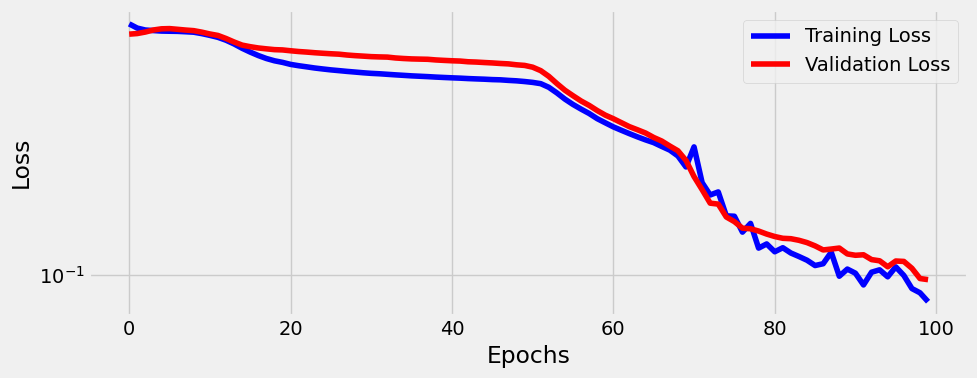

In [ ]:
fig = sbs_rnn.plot_losses()

In [ ]:
StepByStep.loader_apply(test_loader, sbs_rnn.correct)

tensor([[50, 53],
        [75, 75]])

Our simple model hit 97.65% accuracy on the test data.

##Visualizing the Model

Let's explore how the model managed to
successfully classify the sequences. We’ll see the following:

* How the model transforms the inputs
* How the classifier separates the final hidden states
* What the sequence of hidden states looks like
* The journey of a hidden state through every transformation, translation, and
activation.

###Transformed Inputs

Let's see
what’s happening to the inputs (data points) before they are added up to the
transformed hidden state:

In [ ]:
state = model.basic_rnn.state_dict()
state["weight_ih_l0"], state["bias_ih_l0"]

(tensor([[-0.5201, -2.6582],
         [-1.7018, -0.4989]]),
 tensor([0.8096, 0.8822]))

Let’s visualize the transformed "perfect" square.

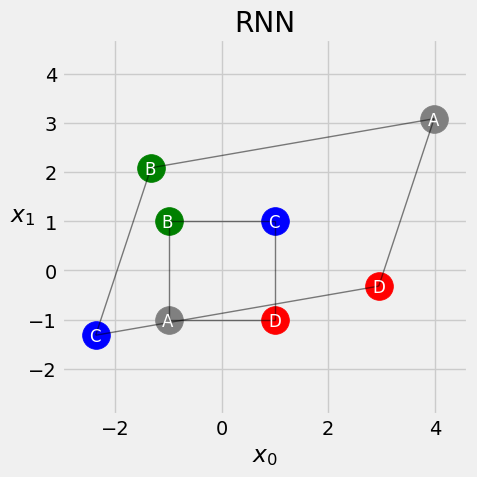

In [ ]:
fig = figure13(model.basic_rnn)

The model learned that it needs to scale, shear, flip, and translate the inputs
(corners) at every step before adding each of them to the transformed hidden
state.

###Hidden States

If we use the "perfect" square as input to our trained model, that’s what the final
hidden states look like for each of the eight sequences.

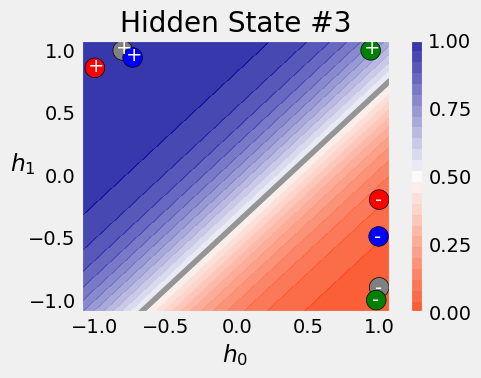

In [ ]:
fig = canonical_contour(model)

What about the other hidden states for the actual sequences?

Let’s visualize them as well.

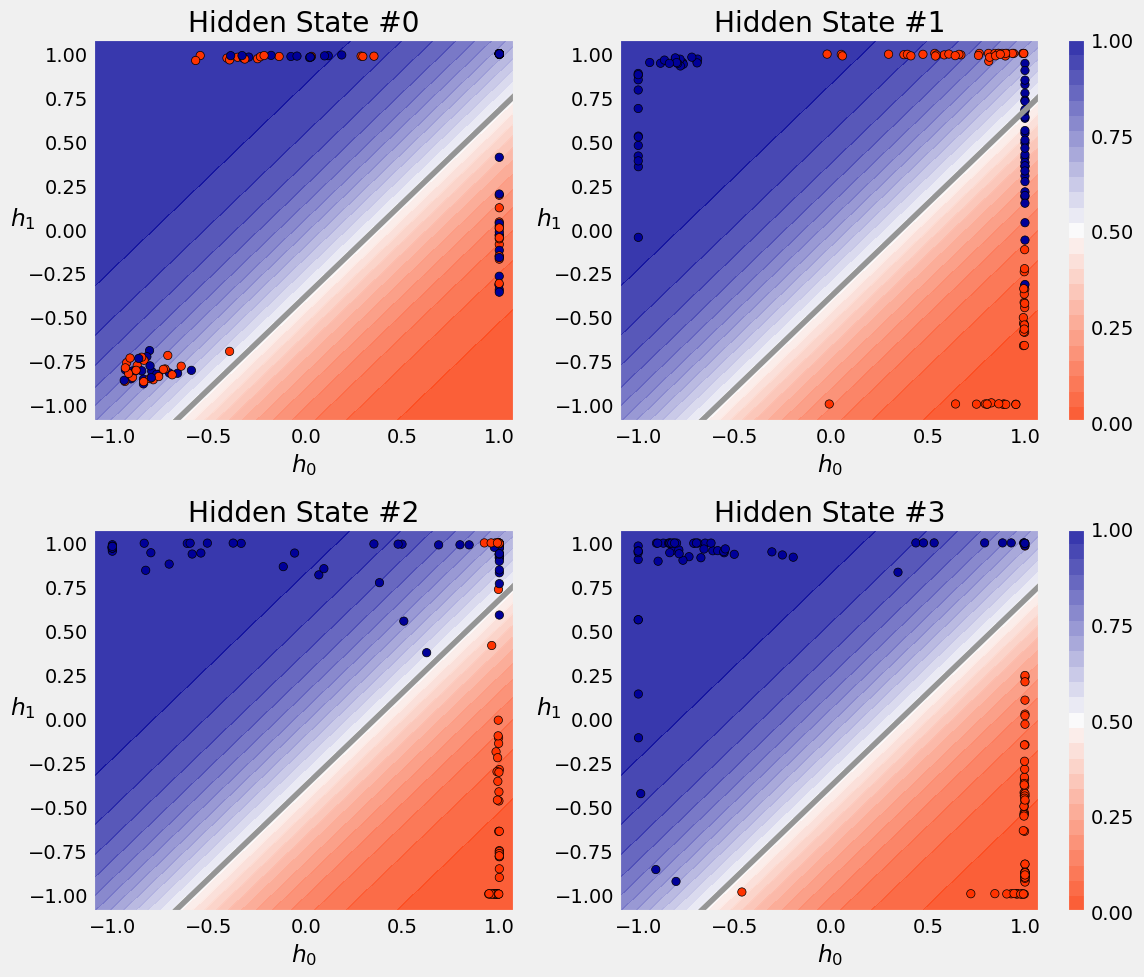

In [ ]:
fig = hidden_states_contour(model, points, directions)

###The Journey of a Hidden State

The figure below tracks the progress of the hidden state over every operation
performed inside the RNN.

The first column has the hidden state that’s an input for the RNN cell at a given
step; the second column has the transformed hidden state; the third, the
translated hidden state (by adding the transformed input); and the last, the
activated hidden state.

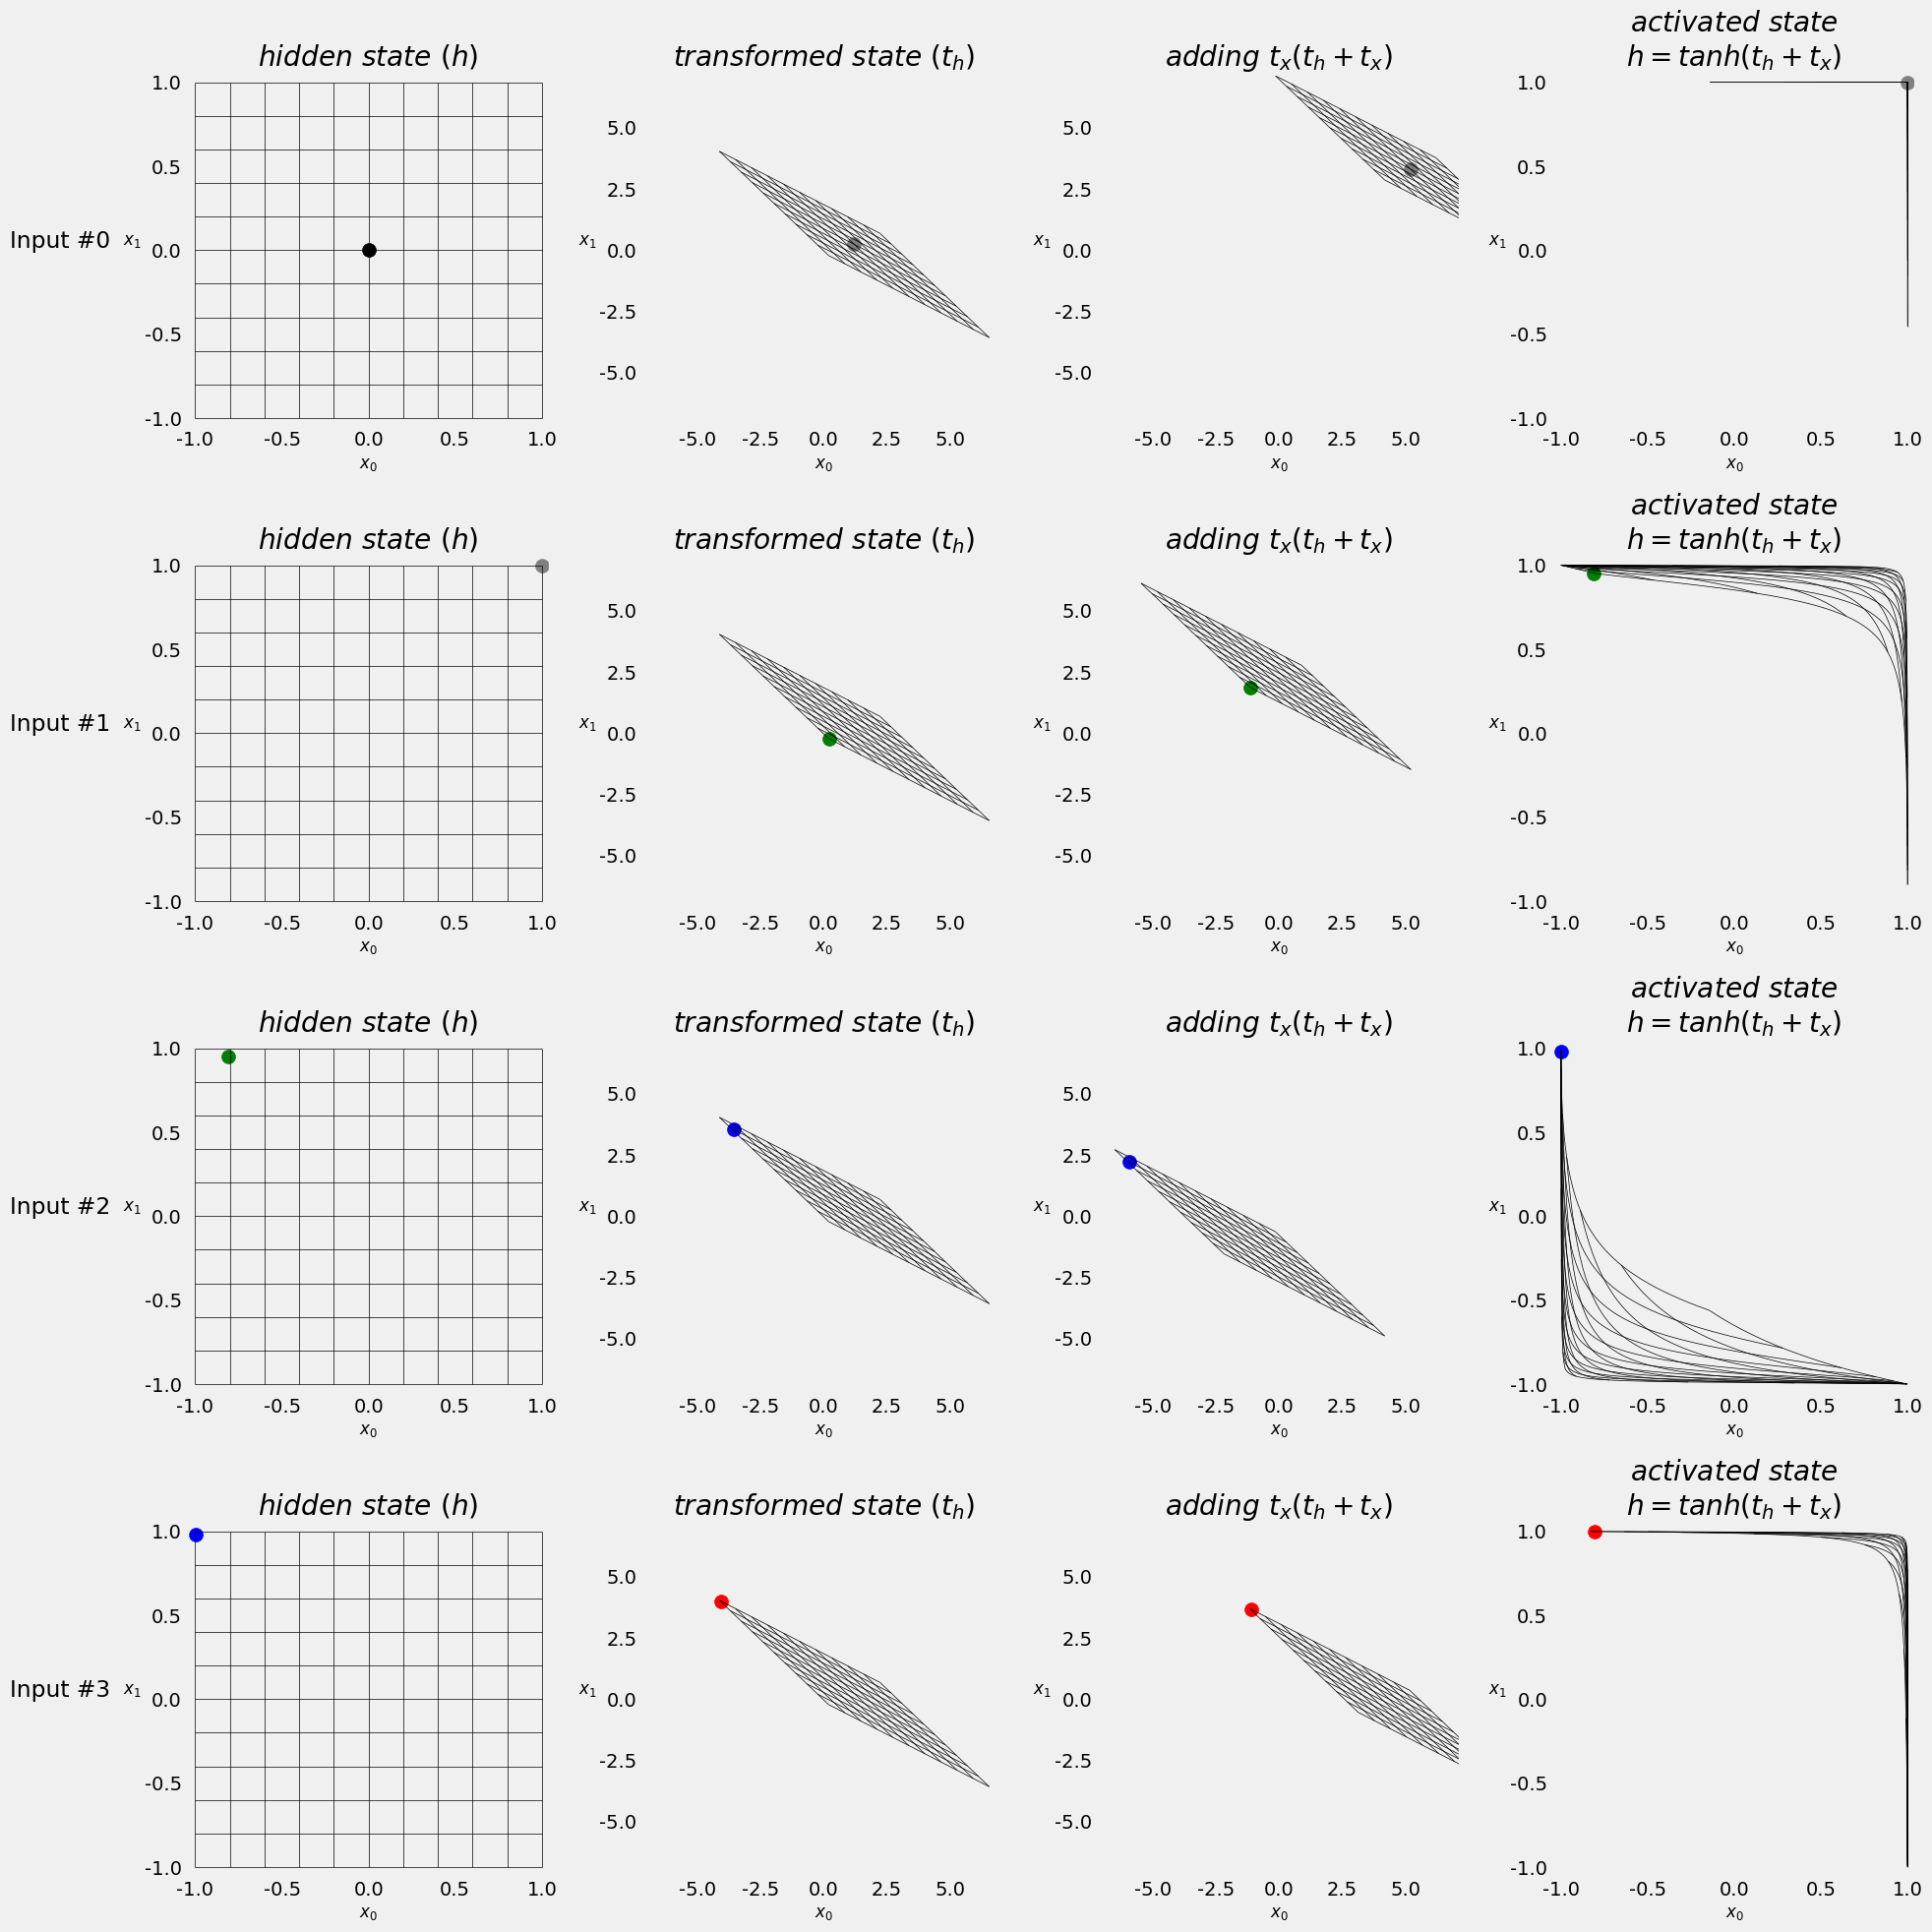

In [ ]:
fig = figure16(model.basic_rnn)

If we connect all the hidden states' positions throughout the whole sequence and
color the path following the assigned colors for each corner, we get to visualize
everything in a single plot in the end.

In [ ]:
square = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
model(square.to(sbs_rnn.device))
model.hidden

tensor([[[-0.8040,  0.9987]]], grad_fn=<StackBackward0>)

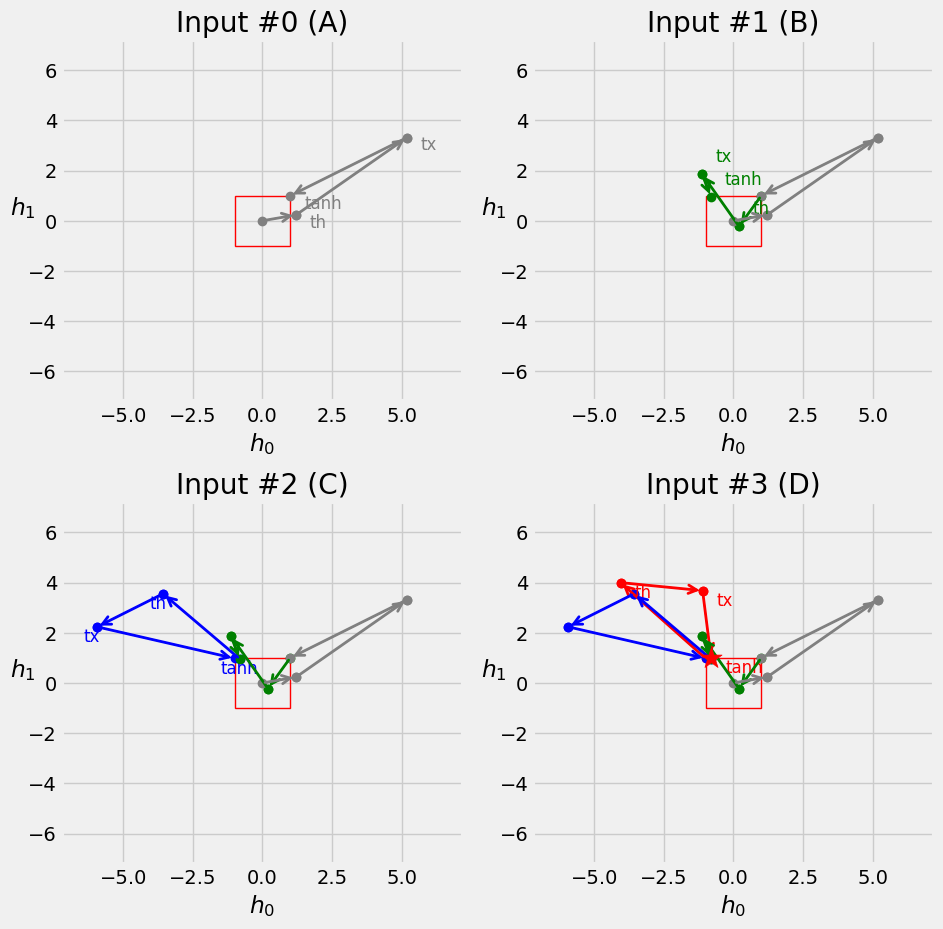

In [ ]:
fig = figure17(model.basic_rnn)

##Gated Recurrent Units (GRUs)